# Baryonic Tully-Fisher Relation #

The goal of this notebook is to demonstrate how to calculate the baryonic tully-fisher distance for a galaxy in APPSS.  The BTF predicts the total baryonic mass based on the 21-cm line width.  If we have expressions for the stellar mass and HI mass in terms of the distance to the galaxy, then we can solve for distance.

In [119]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Measure HI velocity width from HI spectrum (W$_{50}$) ##

The HI velocity width in units of km/s.

In [33]:
W50 = 272.

For convenience, I am going to list all of the other measured quantities that we need for each galaxy.  This will make it easier to calculate the distance for a different galaxy.  The values that I am using for this example are made up.

In [98]:
ba = 0.67 # observed axis ratio of galaxy 
flux_HI = .89 # HI flux in units of Jy-km/s
g = 15.29 # SDSS apparent g-band magnitude
i = 14.19 # SDSS apparent i-band magnitude
vr = 5287.

# galactic extinction from NED
# http://ned.ipac.caltech.edu/cgi-bin/objsearch?search_type=Obj_id&objid=6997&objname=1&img_stamp=YES&hconst=73.0&omegam=0.27&omegav=0.73&corr_z=1
A_g = 0.369
A_i = 0.19

## Correct velocity width for inclination ##

We assume that the spiral galaxies is similar to a pancake; they are circular when viewed face on, and they have a much smaller dimension perpendicular to their face.  

The ellipticity that we observe is then due to the orientation of the galaxy.  We can express this observed elongation in terms of the axis ration of the galaxy, $b/a$.

By definition, the inclination angle is the angle between your line of sight and the area vector that is oriented perpendicular to the plane of the galaxy.  The inclination angle is $0^\circ$ for a face-on galaxy and $90^\circ$ for an edge-on galaxy.

We are using the relationship from Stark, McGaugh, & Swaters (2009) to relate the inclination angle to the observed axis ratio.

$$ sin i = \sqrt{\frac{1 - (b/a)^2}{1 - 0.15^2} }$$

In [44]:
inclination = np.arcsin((1-ba**2)/(1-.15**2))
print 'inclination = %.1f degrees'%(np.degrees(inclination))

inclination = 65.7 degrees


## Use BTF to get total baryonic mass ##

Use calibration from Stark, McGaugh, & Swaters (2009; http://adsabs.harvard.edu/abs/2009AJ....138..392S) to get the baryonic mass

$$\log_{10} M_b = 3.94 \log_{10} v_f + 1.79$$

where 

$$ M_b = M_\star + M_{gas} $$ 

and 

$$v_f = v_{obs}/sini $$

$v_{obs}$ is $W_{50}$.


In [45]:
vf = W50/np.sin((inclination))
log_Mb = 3.94 * np.log10(vf) + 1.79
print 'log(Mb) = %.2f'%(log_Mb)
Mb = 10.**log_Mb

log(Mb) = 9.83


## Get Expression for gas mass ##

The gas mass should include both the molecular and atomic gas, where the molecular gas is traced by CO, for example, and the atomic gas mass is traced by HI.  For now we will approximate the gas mass as this HI mass, but we should add a correction to account for the molecular gas at a later date.  


** HI Mass **

We calculate the HI mass as a function of distance from the HI line flux (Roberts 1962), according to the conversion given here http://egg.astro.cornell.edu/alfalfa/ugrad/himass.htm.

$$M_{HI} = 2.36 \times 10^5 \times F_{HI} \times d_{Mpc}^2$$

where $F_{HI}$ is the integrated flux from HI in units of Jy-km/s.


Papastergis+2016 (https://www.aanda.org/articles/aa/full_html/2016/09/aa28410-16/aa28410-16.html) assume

$$ M_{gas} = 1.33 \times M_{HI} $$


In [46]:
MHI_per_distance2 = 2.36e5 * flux_HI

## Correct SDSS Magnitudes for Galactic and Internal Redenning ##

We need to correct the observed SDSS magnitudes for galactic and internal redenning.  

Internal extinction correction from Gavazzi+2013

https://www.aanda.org/articles/aa/pdf/2013/05/aa20916-12.pdf

$$ (g - i)_{0} = (g - i) - \left( +0.17 \left[1 - cos(inclination) \right] \left[\log\left(\frac{M_\star}{M_\odot} \right) - 8.19 \right] \right) $$

In [103]:
# Galactic extinction

i_corrected = i - A_i
g_corrected = g - A_g

#internal extinction

H0 = 70. #km/s/Mpc
d_estimate = vr/H0
Mi_estimate = i_corrected - 5.*np.log10(d_estimate)
log_mstar_estimate = 1.15 + 0.70*(g_corrected-i_corrected) - 0.4*(i_corrected - 5.*np.log10(d_estimate*1.e6)+5)
print log_mstar_estimate
gi_corrected = g_corrected - i_corrected - (0.17*(1 - np.cos(inclination))*(log_mstar_estimate - 8.19))
print g_corrected-i_corrected,gi_corrected

9.95092254078
0.921 0.868045422458


## Estimate Stellar Mass ##


Estimate the stellar mass using Taylor+2011 (http://adsabs.harvard.edu/abs/2011MNRAS.418.1587T; Chabrier IMF) relation, express in terms of distance. (accuracy of 0.1 dex)  Taylor+2011 gives:

$$\log_{10} \left( \frac{M_\star}{M_\odot}\right) = 1.15 + 0.70 (g-i) - 0.4 M_i $$

and the distance modulus ($m - M = 5 \log_{10}d_{pc} - 5$) gives:

$$ M_i = m_i - 5 \log_{10} d_{pc} + 5 = i - 5 \log_{10} d_{pc} + 5 $$

We can combine the above two equations to get:

$$\log_{10} \left( \frac{M_\star}{M_\odot}\right) = 1.15 + 0.70 (g-i) - 0.4 (i - 5 \log_{10} d_{pc} + 5 ) $$

Distribute $-0.4$:
$$\log_{10} \left( \frac{M_\star}{M_\odot}\right) = 1.15 + 0.70 (g-i) - 0.4 i + 2 \log_{10} d_{pc} - 2  $$

Bring factor in front of log inside the log for distance term:
$$\log_{10} \left( \frac{M_\star}{M_\odot}\right) = 1.15 + 0.70 (g-i) - 0.4 i + \log_{10} (d_{pc}^2) - 2  $$



We want the distance to be in units of Mpc, so we can manipulate the $\log_{10} (d_{pc}^2)$ expression (I have a sign issue here):

$$\log_{10} (d_{pc}^2)  = \log_{10} \left({d_{Mpc}^2}\right) + 12 $$

Going back and substituting into stellar mass equation gives:
$$\log_{10} \left( \frac{M_\star}{M_\odot}\right) = \log_{10} \left({d_{Mpc}^2}\right) + 12 + 1.15 + 0.70 (g-i) - 0.4 i  - 2  $$


$$\log_{10} \left( \frac{M_\star}{M_\odot}\right) = \log_{10} \left({d_{Mpc}^2}\right) + 1.15 + 0.70 (g-i) - 0.4 i  + 10  $$


$$\frac{M_\star}{M_\odot} = d_{Mpc}^2 \times 10^{1.15 +0.7(g-i) - 0.4 i + 10}  $$


In [64]:
Mstar_per_distance2 = 10.**(1.15 + 0.7*(gi_corrected) - 0.4*i_corrected +10)

## Combine Mass Equations ##

We can now combine the stellar mass and HI mass equations to get an expression for the baryonic mass in terms of distance.

$$ M_b = d_{Mpc}^2 \times 10^{1.15 +0.7(g-i) - 0.4 i - 14} + 2.36 \times 10^5 \times F_{HI} \times d_{Mpc}^2 $$ 

$$ M_b = d_{Mpc}^2 \left( 10^{1.15 +0.7(g-i) - 0.4 i - 14} + 2.36 \times 10^5 \times F_{HI} \right) $$

Solving for distance gives:

$$d_{Mpc} = \sqrt{ \frac{M_b}{10^{1.15 +0.7(g-i) - 0.4 i - 14} + 2.36 \times 10^5 \times F_{HI}}} $$

In [65]:
distance_Mpc = np.sqrt(Mb/(Mstar_per_distance2 + MHI_per_distance2))
print 'distance = %.2f (Mpc)' %(distance_Mpc)

distance = 59.97 (Mpc)


## In One Fell Swoop ##

Here is all the code in two cells so you can calculate distances more quickly.  Of course, an even better idea is to write your own program.

In [109]:
# 120300
W50 = .
ba = 0.667 # observed axis ratio of galaxy 
flux_HI = .89 # HI flux in units of Jy-km/s
g = 15.29 # SDSS apparent g-band magnitude
i = 14.19 # SDSS apparent i-band magnitude


vr = 5287.

# galactic extinction from NED
# http://ned.ipac.caltech.edu/cgi-bin/objsearch?search_type=Obj_id&objid=6997&objname=1&img_stamp=YES&hconst=73.0&omegam=0.27&omegav=0.73&corr_z=1
A_g = 0.369
A_i = 0.19


In [ ]:

W50 = 70.
ba = 0.667 # observed axis ratio of galaxy 
flux_HI = .89 # HI flux in units of Jy-km/s
g = 15.29 # SDSS apparent g-band magnitude
i = 14.19 # SDSS apparent i-band magnitude


vr = 5287.

# galactic extinction from NED
# http://ned.ipac.caltech.edu/cgi-bin/objsearch?search_type=Obj_id&objid=6997&objname=1&img_stamp=YES&hconst=73.0&omegam=0.27&omegav=0.73&corr_z=1
A_g = 0.369
A_i = 0.19

In [111]:
# AGC 322551
RA = 339.65
DEC = 25.14278
W50 = 254.
ba = 0.3333 # observed axis ratio of galaxy 
flux_HI = .505 # HI flux in units of Jy-km/s
g = 18.22 # SDSS apparent g-band magnitude
i = 17.55 # SDSS apparent i-band magnitude


vr = 6355.37

# galactic extinction from NED
# http://ned.ipac.caltech.edu/cgi-bin/objsearch?search_type=Obj_id&objid=6997&objname=1&img_stamp=YES&hconst=73.0&omegam=0.27&omegav=0.73&corr_z=1
A_g = 0.
A_i = 0.

In [112]:
inclination = np.arcsin((1-ba**2)/(1-.15**2))

# Galactic extinction

i_corrected = i - A_i
g_corrected = g - A_g

#internal extinction

H0 = 70. #km/s/Mpc
d_estimate = vr/H0
Mi_estimate = i_corrected - 5.*np.log10(d_estimate)
log_mstar_estimate = 1.15 + 0.70*(g_corrected-i_corrected) - 0.4*(i_corrected - 5.*np.log10(d_estimate*1.e6)+5)
gi_corrected = g_corrected - i_corrected - (0.17*(1 - np.cos(inclination))*(log_mstar_estimate - 8.19))
#print g_corrected-i_corrected,gi_corrected

vf = W50/np.sin((inclination))
log_Mb = 3.94 * np.log10(vf) + 1.79

Mb = 10.**log_Mb
MHI_per_distance2 = 2.36e5 * flux_HI
Mstar_per_distance2 = 10.**(1.15 + 0.7*(gi_corrected) - 0.4*i_corrected +10)

distance_Mpc = np.sqrt(Mb/(Mstar_per_distance2 + MHI_per_distance2))

print 'INPUTS'
print '------------------------'
print 'W50 = ',W50
print 'b/a = ',ba
print '(inclination = %.1f degrees)'%(np.degrees(inclination))
print 'HI flux = ',flux_HI
print 'g = ',g
print 'i = ',i
print ''
print 'MASS - 2 log(d_Mpc)'
print '------------------------'
print 'log(M*/d^2) = %.2f'%(np.log10(Mstar_per_distance2))
print 'log(MHI/d^2) = %.2f'%(np.log10(MHI_per_distance2))
print ''

print 'BARYONIC MASS FROM BTFR'
print '------------------------'
print 'log(Mb) = %.2f'%(log_Mb)
print ''
print 'BTFR DISTANCE'
print '------------------------'
print 'distance = %.2f (Mpc)' %(distance_Mpc)
print ''
print 'CORRESPONDING MASSES'
print '------------------------'
print 'log(M*) = %.2f'%(np.log10(Mstar_per_distance2)+2.*np.log10(distance_Mpc))
print 'log(MHI) = %.2f'%(np.log10(MHI_per_distance2)+2.*np.log10(distance_Mpc))

INPUTS
------------------------
W50 =  254.0
b/a =  0.3333
(inclination = 65.4 degrees)
HI flux =  0.505
g =  18.22
i =  17.55

MASS - 2 log(d_Mpc)
------------------------
log(M*/d^2) = 4.53
log(MHI/d^2) = 5.08

BARYONIC MASS FROM BTFR
------------------------
log(Mb) = 11.43

BTFR DISTANCE
------------------------
distance = 1322.22 (Mpc)

CORRESPONDING MASSES
------------------------
log(M*) = 10.77
log(MHI) = 11.32


## Calculating Masses Assuming Hubble Distance ##

We are going to try a different approach.  Let's assume the recession velocity is due to the Hubble flow, and calculate the corresponding distance to the galaxy.

Then calculate the HI mass and stellar mass based on this distance.

Plot the galaxy on the baryonic tully fisher relation.




In [130]:
# 120300
W50 = 272.
ba = 0.667 # observed axis ratio of galaxy 
flux_HI = .89 # HI flux in units of Jy-km/s
g = 15.29 # SDSS apparent g-band magnitude
i = 14.19 # SDSS apparent i-band magnitude


vr = 5287.

# galactic extinction from NED
# http://ned.ipac.caltech.edu/cgi-bin/objsearch?search_type=Obj_id&objid=6997&objname=1&img_stamp=YES&hconst=73.0&omegam=0.27&omegav=0.73&corr_z=1
A_g = 0.369
A_i = 0.19


# make arrays
ids = [120300,321315]
W50 = np.array([272,151],'f')
ba = np.array([.667,.333],'f')
flux_HI = np.array([.89,.505],'f')
g = np.array([15.29,18.82],'f')
i = np.array([14.19,18.30],'f')
vr = np.array([5287.,6355.],'f')
A_g =np.array([.369,0.1,],'f')
A_i = np.array([.19,0.1],'f')

In [131]:
inclination = np.arcsin((1-ba**2)/(1-.15**2))

# Galactic extinction

i_corrected = i - A_i
g_corrected = g - A_g

#internal extinction

H0 = 70. #km/s/Mpc
d_estimate = vr/H0
Mi_estimate = i_corrected - 5.*np.log10(d_estimate)
log_mstar_estimate = 1.15 + 0.70*(g_corrected-i_corrected) - 0.4*(i_corrected - 5.*np.log10(d_estimate*1.e6)+5)
gi_corrected = g_corrected - i_corrected - (0.17*(1 - np.cos(inclination))*(log_mstar_estimate - 8.19))
#print g_corrected-i_corrected,gi_corrected
# correct for internal extinction
log_mstar_estimate = 1.15 + 0.70*(gi_corrected) - 0.4*(i_corrected - 5.*np.log10(d_estimate*1.e6)+5)

vf = W50/np.sin((inclination))

MHI_estimate = 2.36e5 * flux_HI *d_estimate**2

Mb_estimate = 10.**log_mstar_estimate + 1.3*MHI_estimate

print 'INPUTS'
print '------------------------'
print 'W50 = ',W50
print 'b/a = ',ba
print '(inclination = %.1f degrees)'%(np.degrees(inclination))
print 'HI flux = ',flux_HI
print 'g = ',g
print 'i = ',i
print ''
print 'MASS ESTIMATES'
print '------------------------'
print 'log(M*) = %.2f'%(log_mstar_estimate)
print 'log(MHI) = %.2f'%(np.log10(MHI_estimate))
print 'log(Mb) = %.2f'%(np.log10(Mb_estimate))
print ''
print 'CORRECTED VELOCITY'
print '------------------------'
print 'vf = %.2f km/s'%(vf)



INPUTS
------------------------
W50 =  [ 272.  151.]
b/a =  [ 0.667  0.333]


TypeError: float argument required, not numpy.ndarray

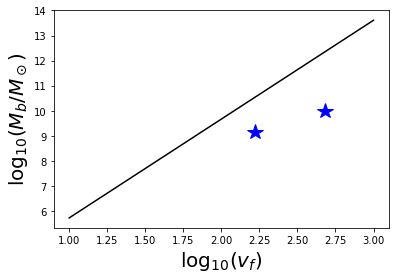

In [132]:
# Figure


# stark relation for Mb vs log(vf)
xl = np.arange(1,3.1,.1)
yl=3.94*xl+1.79


plt.figure()
plt.plot(xl,yl,'k-')
plt.plot(np.log10(vf),np.log10(Mb_estimate),'b*',markersize=16)

plt.xlabel('$\log_{10}(v_f)$',fontsize=20)
plt.ylabel('$\log_{10}(M_b/M_\odot)$',fontsize=20)
